In [541]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd

### Define constants

In [595]:
r = 0.5
rs = 0.9

z_range = 10
n = 4000
inc = z_range / n

In [596]:
galton_r = 0.511
galton_rs = 0.902

### Create the population

In [597]:
%%time
# Parent Generation
px = np.linspace(-z_range/2, z_range/2, n)
py = np.exp(-px**2/2) / (2*np.pi)**0.5
parea = np.trapz(py, px)
psd = np.sqrt(sum(py*px**2) / sum(py))

CPU times: user 2.31 ms, sys: 265 µs, total: 2.57 ms
Wall time: 2.44 ms


In [598]:
%%time
# Individual Offspring distributions
oxs = rs*px + r*px.reshape(-1, 1)
oys = py * py.reshape(-1, 1)

CPU times: user 62.6 ms, sys: 38.2 ms, total: 101 ms
Wall time: 99.8 ms


In [599]:
ox = px  # remember these are defined to be the same
oys = py * py.reshape(-1, 1)

#### Correlation coefficient

In [36]:
%%time
# Offspring Generation
oys_interp = np.array([np.interp(ox, oxs[i], oys[i], 
                    left=0, right=0) for i in range(n)])
oy = oys_interp.sum(axis=0)
oarea = np.trapz(oy, ox)
oy = oy * parea / oarea  # parea is essential equal to one
osd = np.sqrt(sum(oy*ox**2) / sum(oy))

CPU times: user 2.02 s, sys: 687 ms, total: 2.71 s
Wall time: 2.74 s


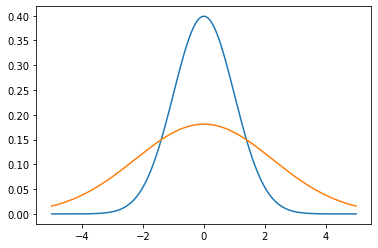

In [37]:
plt.plot(px, py)
plt.plot(ox, oy);

### Example of the edge

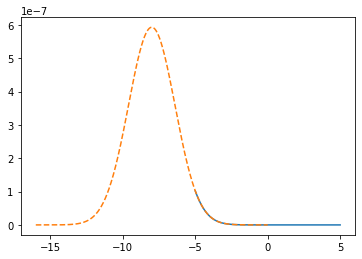

In [38]:
plt.plot(px, oys_interp[0])
plt.plot(oxs[0], oys[0], linestyle='--');

#### Possibilities
* Get expectation of the parent phenotype score as a function of offspring phenotype score.
* Get five distributions of the parent phenotypes for each of the five offspring quintiles. (Attributable.)
* Do the reverse as above - get five distributions of the offspring phenotypes for each of the five parent quintiles. (Destined.)
* Generate the standard deviation over all different pairs of `(r, rs)`. With 2.3 seconds per run, and 3,600 points (r from 0.1 to 1.6 and rs from 0.1 to 1.6, increments of 0.025) that would take 2.3 hours. We could do it in an hour with smaller `n`. 

## Parameter space

In [7]:
def get_sd(r, rs):
    # Individual Offspring distributions
    oxs = rs*px + r*px.reshape(-1, 1)
    
    # Offspring Generation
    oys_interp = np.array([np.interp(ox, oxs[i], oys[i], 
                        left=0, right=0) for i in range(n)])
    oy = oys_interp.sum(axis=0)
    oarea = np.trapz(oy, ox)
    oy = oy * parea / oarea  # parea is essential equal to one
    osd = np.sqrt(sum(oy*ox**2) / sum(oy))
    
    return osd

In [118]:
n_grid = 64

r_space = np.linspace(0.025, 1.6, n_grid)

rv, rsv = np.meshgrid(r_space, r_space)

sdv = np.zeros((n_grid, n_grid))

In [111]:
for i in range(n_grid):
    for j in range(n_grid):
        print(i, j)
        sdv[i, j] = get_sd(rv[i, j], rsv[i, j])

In [536]:
r = 0.5

In [537]:
np.sqrt(1-r**2)

0.8660254037844386

In [538]:
get_sd(r, np.sqrt(1-r**2))

0.9999864839991471

In [539]:
get_sd(r, 0.91)

1.038292182041966

In [123]:
df = pd.read_csv('r_columns_rs_rows.csv', index_col=0)
df.columns = r_space

In [125]:
sdv = df.to_numpy()

In [126]:
dec = 3

In [127]:
np.array_equal(np.round(sdv, decimals=dec).T, np.round(sdv, decimals=dec))

True

In [128]:
dec = 4

In [129]:
np.round(sdv, decimals=dec)[
    np.where((np.round(sdv, decimals=dec).T != np.round(sdv, decimals=dec)))]

array([1.0526, 1.0527])

In [130]:
rv[np.where((np.round(sdv, decimals=dec).T != np.round(sdv, decimals=dec)))]

array([1.05 , 0.075])

In [132]:
sdv

array([[0.03535508, 0.05590129, 0.07905635, ..., 1.53917   , 1.56219274,
        1.58497729],
       [0.05590129, 0.07071015, 0.09013811, ..., 1.53972959, 1.56273794,
        1.58550823],
       [0.07905636, 0.09013812, 0.10606523, ..., 1.54066147, 1.56364585,
        1.58639241],
       ...,
       [1.53917007, 1.53972967, 1.54066154, ..., 2.03511564, 2.04578527,
        2.05637909],
       [1.56219282, 1.56273802, 1.56364593, ..., 2.04578527, 2.05621415,
        2.06657074],
       [1.58497737, 1.58550831, 1.58639248, ..., 2.05637909, 2.06657074,
        2.07669352]])

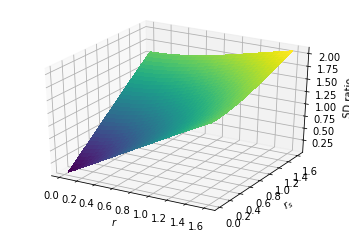

In [208]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(rv, rsv, sdv, cmap='viridis',
                       linewidth=0, antialiased=False)
ax.set_xlabel('$r$')
ax.set_ylabel('$r_s$')
ax.set_zlabel('SD ratio')
plt.show()

In [230]:
plt.style.use('default')

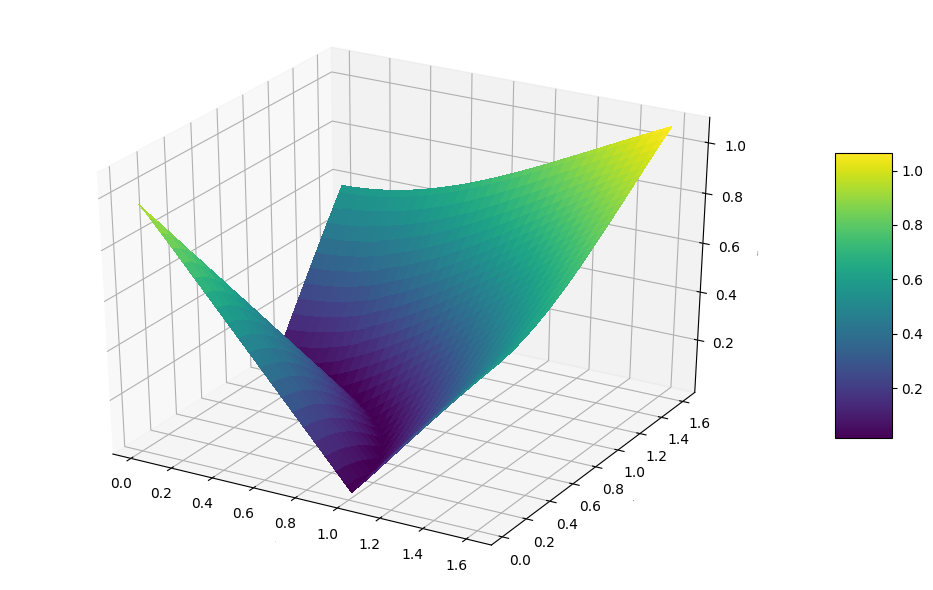

In [504]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(rv, rsv, abs(sdv - 1), cmap='viridis',
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$r$', fontsize=1)
ax.set_ylabel('$r_s$', fontsize=1)
ax.set_zlabel('SD Diff.', fontsize=1)
plt.tight_layout()
plt.savefig('parameters-surface-unsmoothed.png', dpi=300)
plt.show()

#### Add smoothing

In [ ]:
from scipy.interpolate import interp2d

f = interp2d(rv, rsv, sdv, kind='cubic')
r_space2 = np.linspace(0.025, 1.6, 10*n_grid)
sdv2 = f(r_space2, r_space2)
rv2, rsv2 = np.meshgrid(r_space2, r_space2)

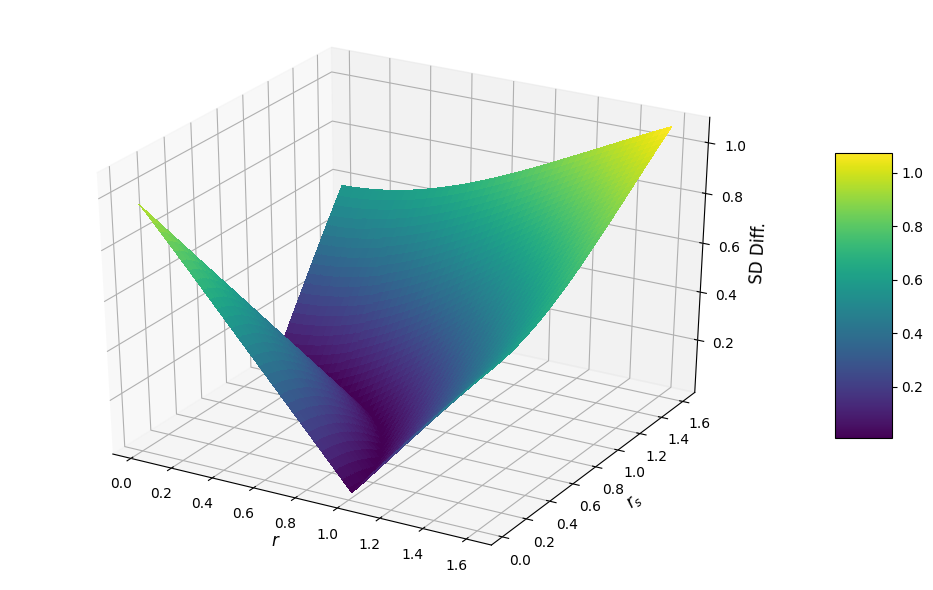

In [505]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(rv2, rsv2, abs(sdv2 - 1), cmap='viridis',
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$r$', fontsize=12)
ax.set_ylabel('$r_s$', fontsize=12)
ax.set_zlabel('SD Diff.', fontsize=12)
plt.tight_layout()
plt.savefig('parameters-surface-cubic_smoothing.png', dpi=300)
plt.show()

### Make circle of radius 1

In [ ]:
x_circle = np.arange(0.025, 1, 0.0005)
y_circle = np.sqrt(1 - x_circle**2)

### Colormesh

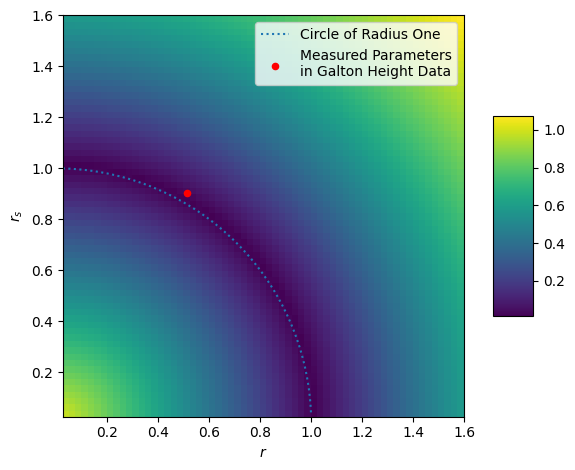

In [506]:
fig = plt.figure()
ax = fig.gca()
ax.pcolormesh(rv, rsv, abs(sdv - 1),
                       linewidth=0, antialiased=False)
plt.scatter(galton_r, galton_rs, color='r', s=20, 
            label='Measured Parameters\nin Galton Height Data')
plt.plot(x_circle, y_circle, label='Circle of Radius One', linestyle=':')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.gca().set_aspect('equal', adjustable='box')

ax.set_xlabel('$r$')
ax.set_ylabel('$r_s$')
plt.legend()
plt.tight_layout()
plt.savefig('parameters-colormesh-unsmoothed.png', dpi=300)

#### Add smoothing

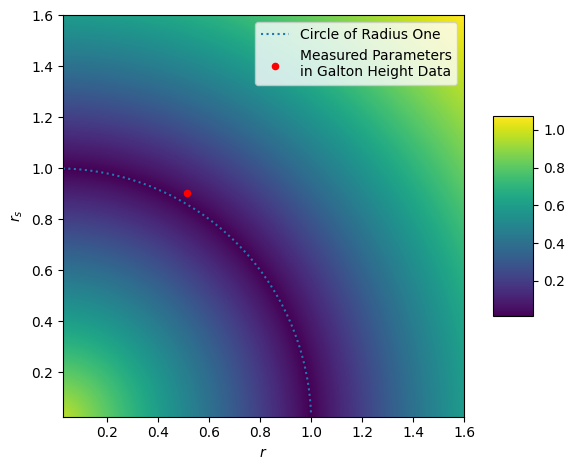

In [507]:
fig = plt.figure()
ax = fig.gca()
ax.pcolormesh(rv2, rsv2, abs(sdv2 - 1),
                       linewidth=0, antialiased=False)
plt.scatter(galton_r, galton_rs, color='r', s=20, 
            label='Measured Parameters\nin Galton Height Data')
plt.plot(x_circle, y_circle, label='Circle of Radius One', linestyle=':')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.gca().set_aspect('equal', adjustable='box')

ax.set_xlabel('$r$')
ax.set_ylabel('$r_s$')
plt.legend()
plt.tight_layout()
plt.savefig('parameters-colormesh-cubic_smoothing.png', dpi=300)
plt.show()

### Get minimum path directly

In [405]:
sdva = abs(sdv-1)
sdva2 = abs(sdv2-1)

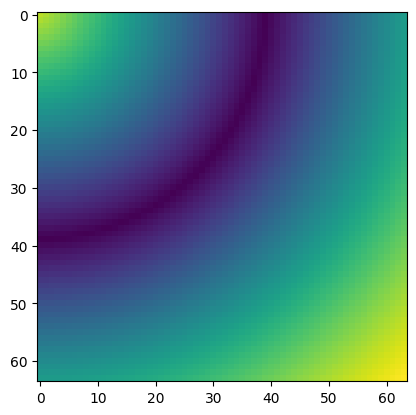

In [385]:
plt.imshow(sdva)

In [386]:
np.argmin(sdva, axis=0)

array([39, 39, 39, 39, 39, 39, 38, 38, 38, 38, 37, 37, 37, 36, 36, 36, 35,
       35, 34, 34, 33, 32, 32, 31, 30, 29, 29, 28, 27, 25, 24, 23, 22, 20,
       18, 16, 14, 11,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [387]:
np.argmin(sdva, axis=1)

array([39, 39, 39, 39, 39, 39, 38, 38, 38, 38, 37, 37, 37, 36, 36, 36, 35,
       35, 34, 34, 33, 32, 32, 31, 30, 29, 29, 28, 27, 25, 24, 23, 22, 20,
       18, 16, 14, 11,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

#### Compare minimum path to circle of radius one

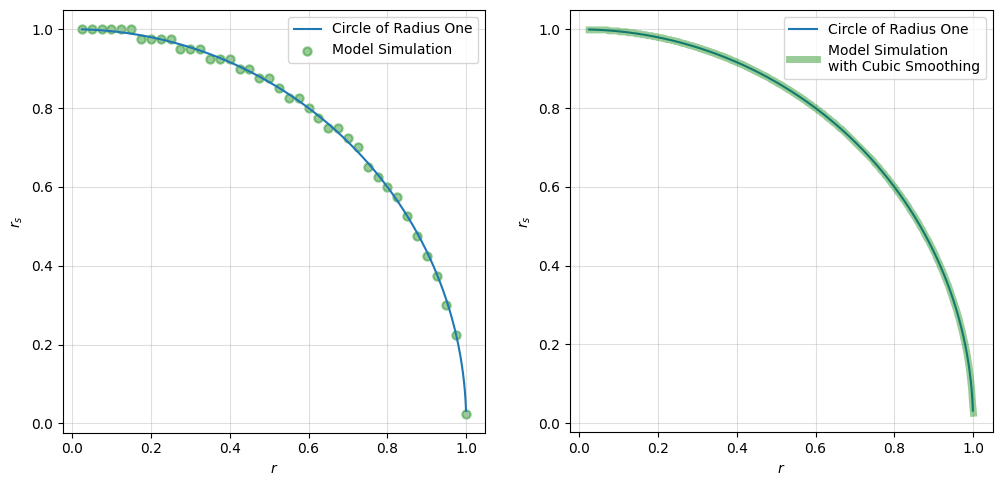

In [509]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(x_circle, y_circle, label='Circle of Radius One', linestyle='-')
ax2.plot(x_circle, y_circle, label='Circle of Radius One', linestyle='-')

ax1.scatter(rv[np.argmin(sdva, axis=1)][0,:][:40], 
         rsv[np.argmin(sdva, axis=0)][:,0][:40], alpha=0.4, linewidth=1.5, c='green',
        label='Model Simulation')

ax2.plot(rv2[np.argmin(sdva2, axis=1)][0,:][:397], 
         rsv2[np.argmin(sdva2, axis=0)][:,0][:397], 
         linewidth=5, alpha=0.4, c='green', 
         label='Model Simulation\nwith Cubic Smoothing')

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')

ax1.set(xlabel='$r$', ylabel='$r_s$')
ax2.set(xlabel='$r$', ylabel='$r_s$')

ax1.legend()
ax2.legend()
ax1.grid(alpha=0.4)
ax2.grid(alpha=0.4)
# plt.tight_layout()
plt.savefig('parameters-compare_to_circle.png', dpi=300)
plt.show()

In [499]:
rv[np.argmin(sdva, axis=1)][0,:][:40]

array([0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225,
       0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 ,
       0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675,
       0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  ,
       0.925, 0.95 , 0.975, 1.   ])

In [500]:
rsv[np.argmin(sdva, axis=0)][:,0][:40]

array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.975, 0.975, 0.975,
       0.975, 0.95 , 0.95 , 0.95 , 0.925, 0.925, 0.925, 0.9  , 0.9  ,
       0.875, 0.875, 0.85 , 0.825, 0.825, 0.8  , 0.775, 0.75 , 0.75 ,
       0.725, 0.7  , 0.65 , 0.625, 0.6  , 0.575, 0.525, 0.475, 0.425,
       0.375, 0.3  , 0.225, 0.025])

In [349]:
(np.argmin(abs(sdv - 1), axis=1) == np.argmin(abs(sdv - 1), axis=0)).all()

True

In [370]:
a = np.array([[4, 6, 7],
              [1, 5, 2],
              [2, 2, 0]])

In [371]:
np.argmin(a, axis=0)

array([1, 2, 2])

In [372]:
np.argmin(a, axis=1)

array([0, 0, 2])

In [373]:
a[np.argmin(a, axis=0), np.argmin(a, axis=1)]

array([1, 2, 0])

## Amazing result!

### $\sigma_2 = \sigma_1 \, \sqrt{r^2 + r_s^2}$ 

### $z_{g} = r \, z_{p}$ 

### $\sigma_g = r_s \, \sigma_1$


* $r$ is the regression coefficient between the expectation of an individual offspring distribution ($g$) and its mid-parental phenotype. Note that $z$ is relative to the parental generation in both cases. 

* $r_s$ is the ratio of the standard deviation of the individual offspring distribution ($g$) to that of the standard deviation of the parental (1st) generation.

Together, these two constants have been shown through computer simulation to determine the standard deviation of the offspring (2nd) generation with remarkable simplicity.

The mid-parental values generally have a smaller spread than the parental generation as a whole because of regression to the mean in mating selection. This model does not take into account mating selection or assumes it is the same from one generation unto the next. Through a simple linear transformation, the mid-parental values can stretch so as to have the same standard deviation as the parental generation or the offspring generation values can be shrunk by the same factor. This does not affect the correlation coefficient between mid-parental phenotypes and the expectation of their individual offspring distribution. 

This model uses field-measured parameter values in which the correlation coefficient between the parental generation and expected parameter values will equal the regression coefficient ($r$) (as in the model). However, for certain parameter values, the offspring generation will not have approximately the same standard deviation as the parent generation (as in the field-measurements) - which means the regression coefficient may no longer equal the correlation coefficient. 

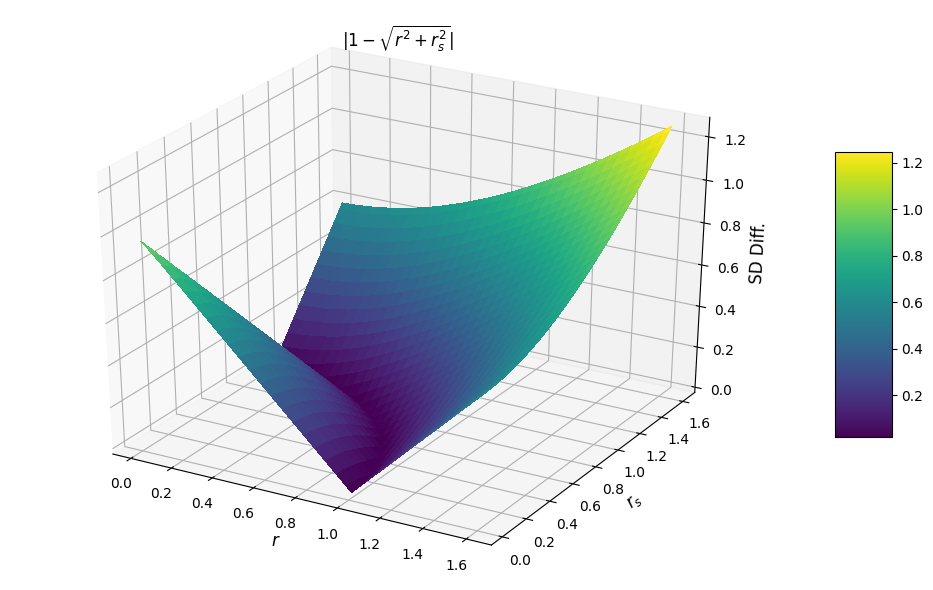

In [532]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(rv, rsv, abs(np.sqrt(rv**2 + rsv**2)-1), cmap='viridis',
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$r$', fontsize=12)
ax.set_ylabel('$r_s$', fontsize=12)
ax.set_zlabel('SD Diff.', fontsize=12)
plt.title('$ |{1 - \sqrt{r^2 + r_s^2}}|$')
plt.tight_layout()
# plt.savefig('parameters-surface-cubic_smoothing.png', dpi=300)
plt.show()

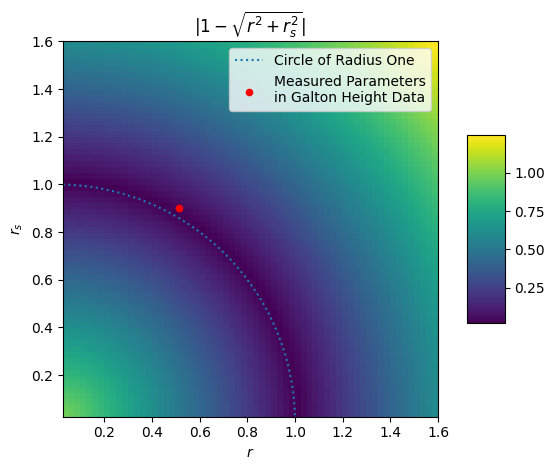

In [533]:
fig = plt.figure()
ax = fig.gca()
ax.pcolormesh(rv, rsv, abs(np.sqrt(rv**2 + rsv**2) - 1),
                       linewidth=0, antialiased=False)
plt.scatter(galton_r, galton_rs, color='r', s=20, 
            label='Measured Parameters\nin Galton Height Data')
plt.plot(x_circle, y_circle, label='Circle of Radius One', linestyle=':')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.gca().set_aspect('equal', adjustable='box')

ax.set_xlabel('$r$')
ax.set_ylabel('$r_s$')
plt.title('$ |{1 - \sqrt{r^2 + r_s^2}}|$')
plt.legend()
plt.tight_layout();

In [516]:
np.sqrt(rv**2 + rsv**2).shape

(64, 64)

In [524]:
(sdv - np.sqrt(rv**2 + rsv**2)).mean()

-0.013294143295860475

In [522]:
(sdv - np.sqrt(rv**2 + rsv**2)).std()

0.026519521497500087

## Symmetry of $r$ and $r_s$

In [ ]:
get_sd(r=0.1, rs=1)

In [ ]:
get_sd(r=1, rs=0.1)

In [89]:
get_sd(r=0.2, rs=0.4)

0.44721029690638037

In [90]:
get_sd(r=0.4, rs=0.2)

0.4472102782050869

In [29]:
get_sd(r=0.5, rs=0.6)

0.7810192000863271

In [30]:
get_sd(rs=0.5, r=0.6)

0.7810191952023158

In [102]:
r1, r2 = 0.5, 0.6

In [103]:
a1 = np.sort((r1*px + r2*px.reshape(-1, 1)).ravel())

In [104]:
a2 = np.sort((r2*px + r1*px.reshape(-1, 1)).ravel())

In [107]:
(a1 == a2).all()

True

In [113]:
(r1*px + r2*px.reshape(-1, 1)).T

array([[-5.5       , -5.49939994, -5.49879988, ...,  0.49879988,
         0.49939994,  0.5       ],
       [-5.49949995, -5.49889989, -5.49829983, ...,  0.49929993,
         0.49989999,  0.50050005],
       [-5.4989999 , -5.49839984, -5.49779978, ...,  0.49979998,
         0.50040004,  0.5010001 ],
       ...,
       [-0.5010001 , -0.50040004, -0.49979998, ...,  5.49779978,
         5.49839984,  5.4989999 ],
       [-0.50050005, -0.49989999, -0.49929993, ...,  5.49829983,
         5.49889989,  5.49949995],
       [-0.5       , -0.49939994, -0.49879988, ...,  5.49879988,
         5.49939994,  5.5       ]])

In [116]:
((r2*px + r1*px.reshape(-1, 1)) == (r1*px + r2*px.reshape(-1, 1)).T).all()

True

In [122]:
a = np.array([1, 2, 5])

In [123]:
a + a.reshape(-1, 1)

array([[ 2,  3,  6],
       [ 3,  4,  7],
       [ 6,  7, 10]])

In [46]:
px

array([-5.       , -4.9989999, -4.9979998, ...,  4.9979998,  4.9989999,
        5.       ])

In [81]:
0.8*px.reshape(-1, 1)[0] + 0.1*px

array([-4.5       , -4.49989999, -4.49979998, ..., -3.50020002,
       -3.50010001, -3.5       ])

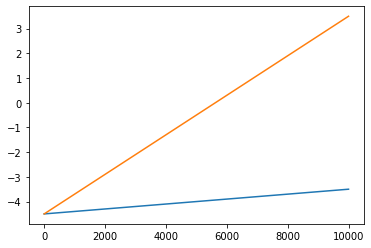

In [88]:
plt.plot(0.8*px.reshape(-1, 1)[0] + 0.1*px)
plt.plot(0.1*px.reshape(-1, 1)[0] + 0.8*px)

In [80]:
0.1*px.reshape(-1, 1)[0] + 0.8*px

array([-4.5       , -4.49919992, -4.49839984, ...,  3.49839984,
        3.49919992,  3.5       ])

In [83]:
0.1*px.reshape(-1, 1)[0] + 0.8*px

array([-4.5       , -4.49919992, -4.49839984, ...,  3.49839984,
        3.49919992,  3.5       ])

In [69]:
px

array([-5.       , -4.9989999, -4.9979998, ...,  4.9979998,  4.9989999,
        5.       ])

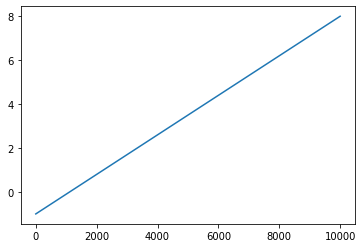

In [58]:
plt.plot((0.1*px.reshape(-1, 1)[0] + 0.8*px) - 0.8*px.reshape(-1, 1)[0] + 0.1*px)

In [45]:
0.1*px + 0.8*px.reshape(-1, 1)

array([[-4.5       , -4.49989999, -4.49979998, ..., -3.50020002,
        -3.50010001, -3.5       ],
       [-4.49919992, -4.49909991, -4.4989999 , ..., -3.49939994,
        -3.49929993, -3.49919992],
       [-4.49839984, -4.49829983, -4.49819982, ..., -3.49859986,
        -3.49849985, -3.49839984],
       ...,
       [ 3.49839984,  3.49849985,  3.49859986, ...,  4.49819982,
         4.49829983,  4.49839984],
       [ 3.49919992,  3.49929993,  3.49939994, ...,  4.4989999 ,
         4.49909991,  4.49919992],
       [ 3.5       ,  3.50010001,  3.50020002, ...,  4.49979998,
         4.49989999,  4.5       ]])

In [44]:
0.8*px + 0.1*px.reshape(-1, 1)

array([[-4.5       , -4.49919992, -4.49839984, ...,  3.49839984,
         3.49919992,  3.5       ],
       [-4.49989999, -4.49909991, -4.49829983, ...,  3.49849985,
         3.49929993,  3.50010001],
       [-4.49979998, -4.4989999 , -4.49819982, ...,  3.49859986,
         3.49939994,  3.50020002],
       ...,
       [-3.50020002, -3.49939994, -3.49859986, ...,  4.49819982,
         4.4989999 ,  4.49979998],
       [-3.50010001, -3.49929993, -3.49849985, ...,  4.49829983,
         4.49909991,  4.49989999],
       [-3.5       , -3.49919992, -3.49839984, ...,  4.49839984,
         4.49919992,  4.5       ]])

### Miscellaneous plots

(-4.0, 4.0)

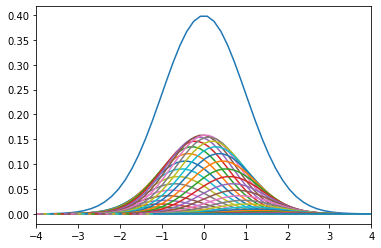

In [132]:
plt.plot(px, py)
for i in range(len(oxs)):
    plt.plot(oxs[i], oys[i])
plt.xlim(-4, 4)

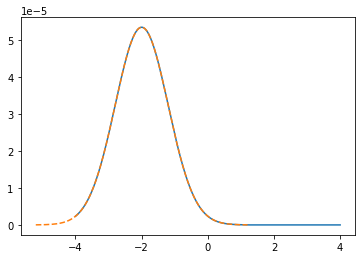

In [8]:
plt.plot(px, oys_interp[0])
plt.plot(oxs[0], oys[0], linestyle='--')

### Object oriented - perhaps later

In [143]:
class Population:
    def __init__(self, r, rs, z_range, n):
        # Parent generation x and y
        self.px = np.linspace(-z_range / 2, z_range/2, n)
        self.py = np.exp(-px**2/2) / (2*np.pi)**0.5

        # Individual Offspring dists. x and y
        self.oxs = rs*px + r*px.reshape(-1, 1)
        self.oys = py * py.reshape(-1, 1)

In [150]:
gen = Population(r, rs, z_range, n)